# Anomaly detection

In [56]:
import sys
import numpy as np
from scipy import stats
import pandas as pd
import random

import entropy
import fractal
import tsfeat

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tqdm import tqdm
tqdm.pandas()

In [57]:
df_normal_all = pd.read_csv('ptbdb_normal.csv',header=None)
df_normal_all = df_normal_all.sample(df_normal_all.shape[0])
df_normal = df_normal_all[:3000].reset_index(drop=True)

# Abnormal TS all have their last value (column 187) to 1
df_abnormal_all = pd.read_csv('ptbdb_abnormal.csv',header=None).drop(187,axis=1)
df_abnormal_all = df_abnormal_all.sample(df_abnormal_all.shape[0])
df_abnormal = df_abnormal_all[:3000].reset_index(drop=True)

# Mix normal and abnormal
df_normal_test = df_normal_all[3000:].sample(500)
df_abnormal_test = df_abnormal_all[3000:].sample(500)

df_normal_test['label'] = 0
df_abnormal_test['label'] = 1
df_test = pd.concat([df_normal_test,df_abnormal_test],ignore_index=True).fillna(0)

In [58]:
# Remove all the filled zeroes to equalize TS size
def pre_processor(arr):
    while arr[-1] == 0:
        arr = arr[:-1].copy()
    return arr

1.5189586825646957


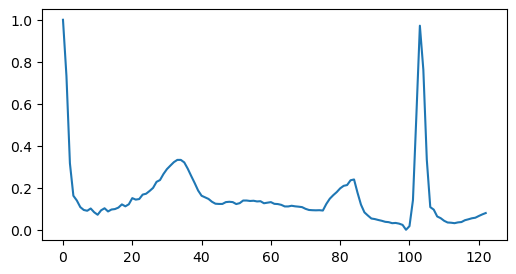

In [146]:
signal = pre_processor(df_normal.sample().iloc[0].values)
fig,ax=plt.subplots(figsize=(6,3))
plt.plot(signal)
print(
    np.correlate(signal, signal, mode='full').mean(),
)

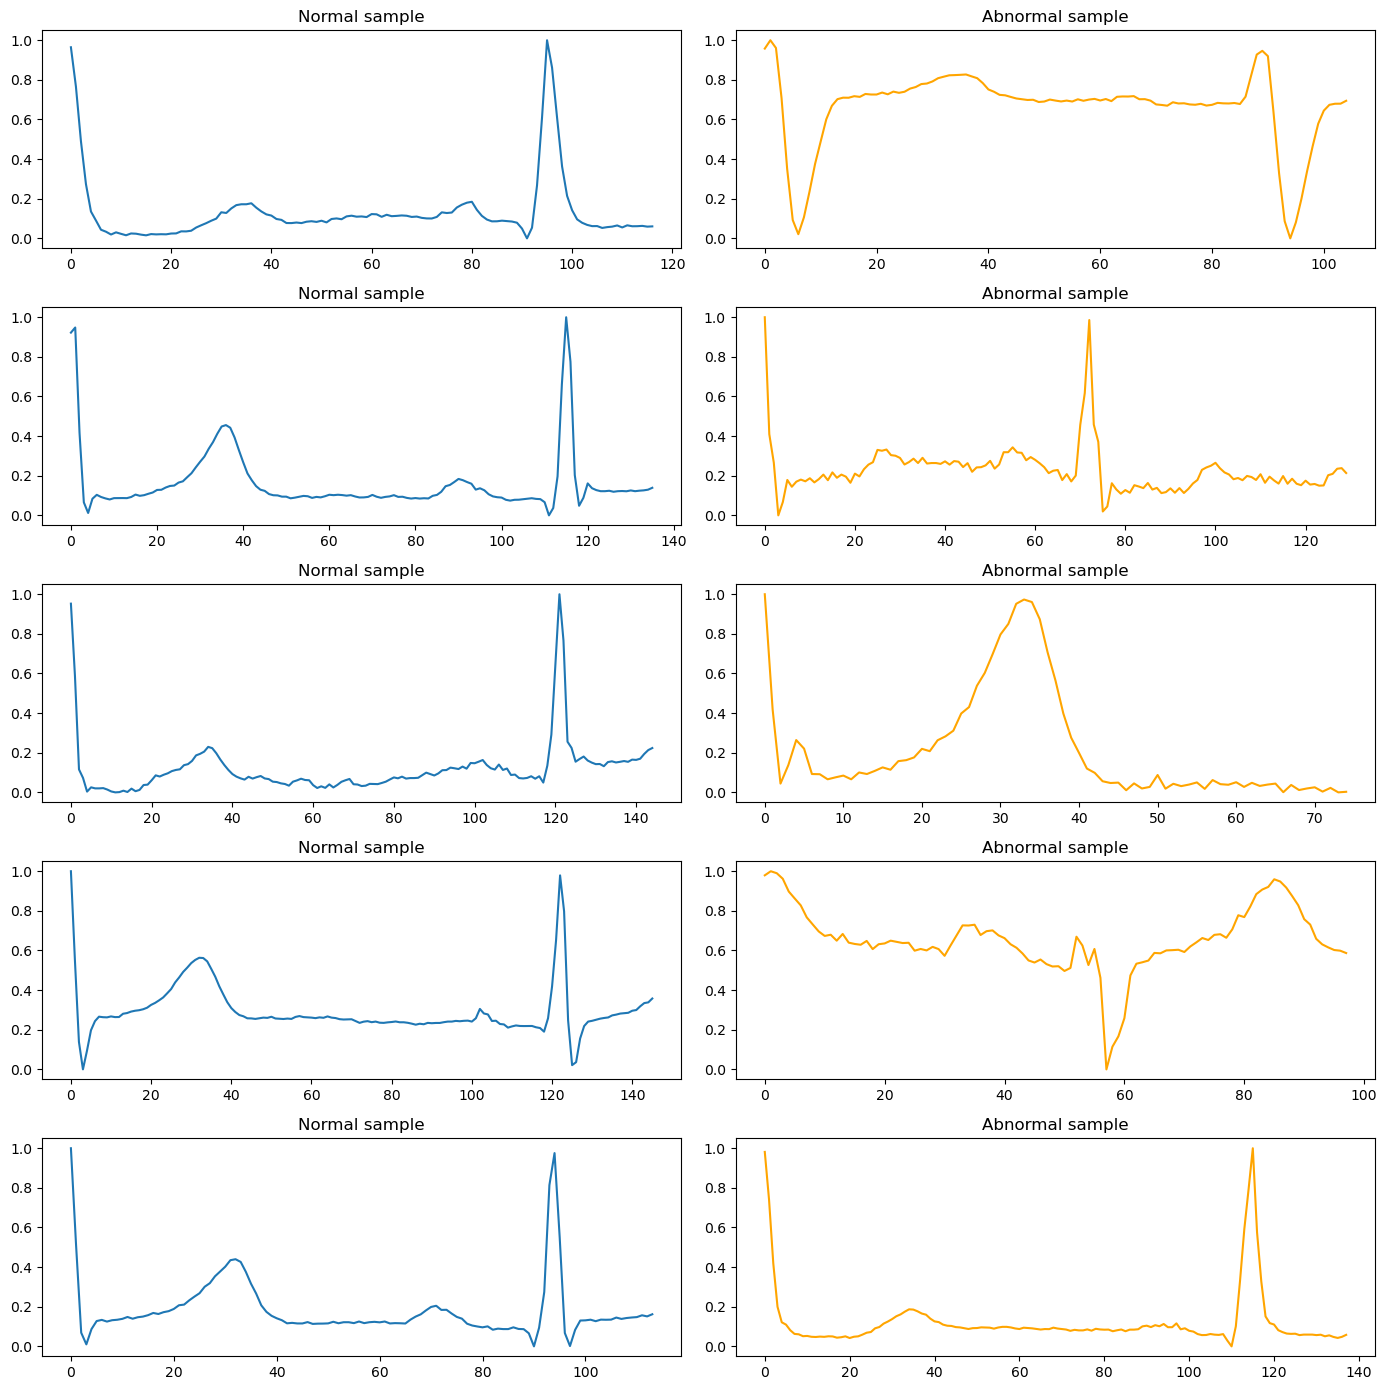

In [62]:
fig,ax=plt.subplots(figsize=(14,14))
c = 1

for idx,idy in zip(random.sample(df_normal.index.tolist(),5),random.sample(df_abnormal.index.tolist(),5)):
    plt.subplot(5,2,c)
    plt.plot(pre_processor(df_normal.iloc[idx].values))
    plt.title('Normal sample')
    plt.subplot(5,2,c+1)
    plt.plot(pre_processor(df_abnormal.iloc[idy].values),color='orange')
    plt.title('Abnormal sample')
    c+=2
plt.tight_layout()

In [94]:
df_FD_normal = pd.DataFrame()
df_FD_abnormal = pd.DataFrame()

print('Processing normal ECG')
for idx in tqdm(range(df_normal.shape[0])):
    signal = pre_processor(df_normal.iloc[idx].values)
    
    row = pd.DataFrame({
        'crest':np.max(np.abs(signal)) / np.sqrt(np.mean(signal*signal)),
        'savgol':abs(signal-savgol_filter(signal,5,2)).sum(),
        'PermEnt': entropy.perm_entropy(signal, order=3, normalize=True),
        #'SVDEnt' : entropy.svd_entropy(signal, order=3, normalize=True),
        'AppEnt': entropy.app_entropy(signal, order=2),
        'SampleEnt': entropy.sample_entropy(signal, order=2),
        'PetrosianFD': fractal.petrosian_fd(signal),
        #'KatzFD': fractal.katz_fd(signal),
        #'HiguchiFD': fractal.higuchi_fd(signal),
        'sparsity':tsfeat.sparsity(signal)['sparsity'],
        'stability':tsfeat.stability(signal)['stability'],
        'peaks':len(find_peaks(signal, height=0)[1]['peak_heights']),
    },index = [0])
    
    df_FD_normal = pd.concat([df_FD_normal, row], ignore_index=True)
    
print('Processing abnormal ECG')
for idx in tqdm(range(df_abnormal.shape[0])):
    signal = pre_processor(df_abnormal.iloc[idx].values)
    
    row = pd.DataFrame({
        'crest':np.max(np.abs(signal)) / np.sqrt(np.mean(signal*signal)),
        'savgol':abs(signal-savgol_filter(signal,5,2)).sum(),
        'PermEnt': entropy.perm_entropy(signal, order=3, normalize=True),
        #'SVDEnt' : entropy.svd_entropy(signal, order=3, normalize=True),
        'AppEnt': entropy.app_entropy(signal, order=2),
        'SampleEnt': entropy.sample_entropy(signal, order=2),
        'PetrosianFD': fractal.petrosian_fd(signal),
        #'KatzFD': fractal.katz_fd(signal),
        #'HiguchiFD': fractal.higuchi_fd(signal),
        'sparsity':tsfeat.sparsity(signal)['sparsity'],
        'stability':tsfeat.stability(signal)['stability'],
        'peaks':len(find_peaks(signal, height=0)[1]['peak_heights']),
    },index = [0])
    
    df_FD_abnormal = pd.concat([df_FD_abnormal, row], ignore_index=True)

Processing normal ECG


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:40<00:00, 29.74it/s]


Processing abnormal ECG


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:18<00:00, 38.13it/s]


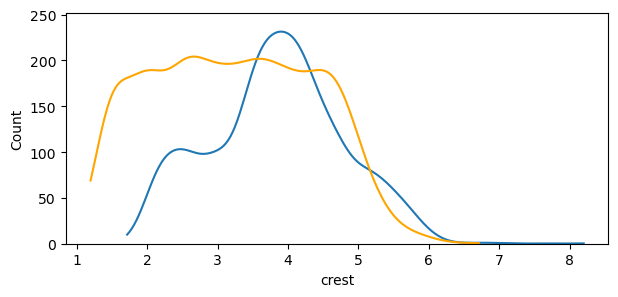

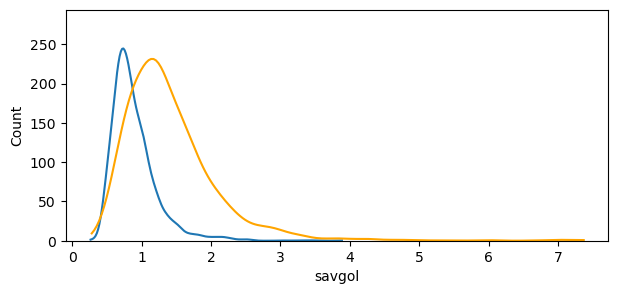

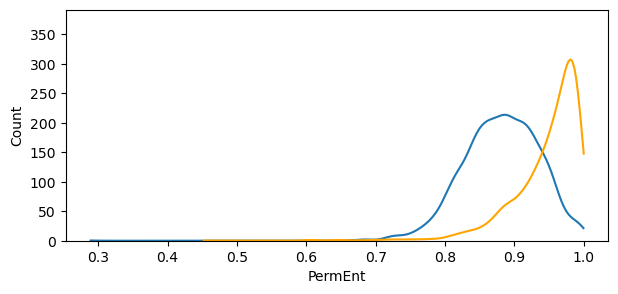

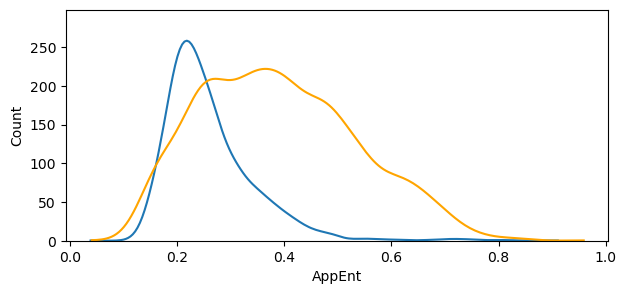

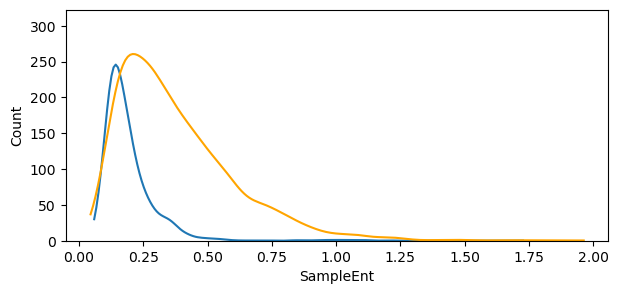

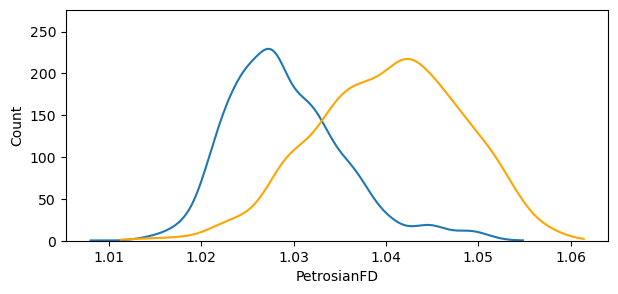

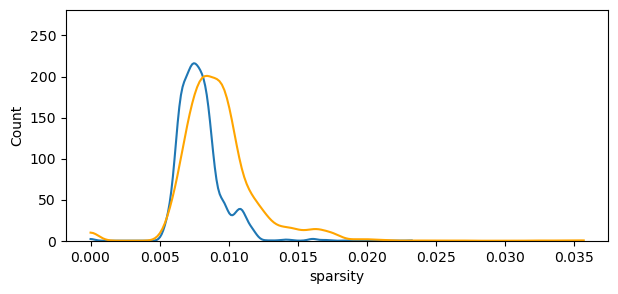

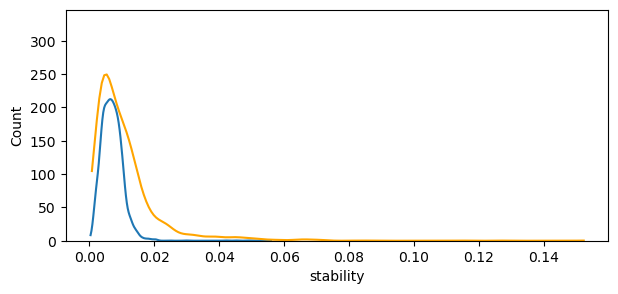

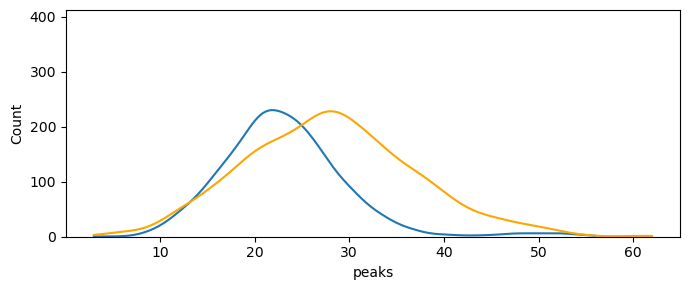

In [95]:
for col in df_FD_normal.columns:
    fig,ax=plt.subplots(figsize=(7,3))
    sns.histplot(df_FD_normal[col],kde=True,alpha=0.,label='normal',linewidth=0)
    sns.histplot(df_FD_abnormal[col],kde=True,color='orange',alpha=0.,label='abnormal',linewidth=0)
    #print(col,stats.ttest_ind(df_FD_normal[col], df_FD_abnormal[col]))

plt.tight_layout()

In [96]:
df_FD_normal['label'] = 0
df_FD_abnormal['label'] = 1

In [97]:
data = pd.concat([df_FD_normal, df_FD_abnormal],ignore_index=True)

In [98]:
data.drop('label',axis=1).columns

Index(['crest', 'savgol', 'PermEnt', 'AppEnt', 'SampleEnt', 'PetrosianFD',
       'sparsity', 'stability', 'peaks'],
      dtype='object')

In [99]:
ML_features = [
    'crest',
    'savgol',
    'PermEnt', 
    #'SVDEnt', 
    'AppEnt', 
    'SampleEnt', 
    'PetrosianFD', 
    #'KatzFD',
    #'HiguchiFD', 
    'sparsity',
    'stability',
    'peaks',
]

In [100]:
X = data[ML_features].values
y = data['label'].values.ravel()

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)
skb = SelectKBest(f_classif)

clf = XGBClassifier(verbosity=1)
pipeline = Pipeline(steps = [
    ("SKB",skb),
    ("CLF",clf)
])   

param_grid = {
    "SKB__k":['all'],
    "CLF__n_estimators":[50,100,200]
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = sss)

In [102]:
%%time
grid.fit(X_train, y_train.ravel())
clf = grid.best_estimator_

y_pred = clf.predict(X_test)
print("\n > Best grid search:\n",grid.best_params_,'\n')

print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 3 candidates, totalling 15 fits

 > Best grid search:
 {'CLF__n_estimators': 200, 'SKB__k': 'all'} 

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       600
           1       0.93      0.91      0.92       600

    accuracy                           0.92      1200
   macro avg       0.92      0.92      0.92      1200
weighted avg       0.92      0.92      0.92      1200

Wall time: 11.6 s


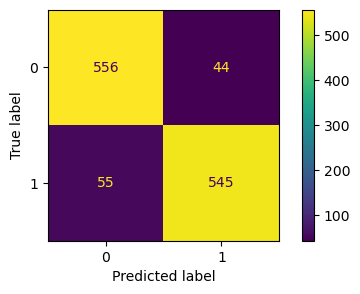

In [103]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)

fig,ax=plt.subplots(figsize=(6,3))
disp.plot(ax=ax);

In [104]:
pd.DataFrame({
    'features':ML_features,
    'importance':grid.best_estimator_.named_steps['SKB'].scores_
}).sort_values('importance',ascending=False)

,features,importance
5,PetrosianFD,2898.057731
2,PermEnt,1803.302453
3,AppEnt,1385.860577
4,SampleEnt,1260.782643
1,savgol,1090.147294
8,peaks,450.955229
6,sparsity,446.505463
0,crest,395.302746
7,stability,281.517486


In [105]:
def random_test():

    idx = random.randint(0,df_test.shape[0])

    signal = df_test.drop('label',axis=1).iloc[idx].values.ravel()
    signal = pre_processor(signal)

    feature_eng = pd.DataFrame({
            'crest':np.max(np.abs(signal)) / np.sqrt(np.mean(signal*signal)),
            'savgol':abs(signal-savgol_filter(signal,5,2)).sum(),
            'PermEnt': entropy.perm_entropy(signal, order=3, normalize=True),
            #'SVDEnt' : entropy.svd_entropy(signal, order=3, normalize=True),
            'AppEnt': entropy.app_entropy(signal, order=2),
            'SampleEnt': entropy.sample_entropy(signal, order=2),
            'PetrosianFD': fractal.petrosian_fd(signal),
            #'KatzFD': fractal.katz_fd(signal),
            #'HiguchiFD': fractal.higuchi_fd(signal),
            'sparsity':tsfeat.sparsity(signal)['sparsity'],
            'stability':tsfeat.stability(signal)['stability'],
            'peaks':len(find_peaks(signal, height=0)[1]['peak_heights']),
        },index = [0])

    display(feature_eng)
    pred = clf.predict_proba(feature_eng[ML_features].values)
    proba = pd.DataFrame(pred,columns=['normal','abnormal'])

    fig,ax=plt.subplots(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(signal, color='r')
    actual = 'Actual: normal' if df_test.label.iloc[idx] == 0 else 'Actual: abnormal'
    plt.title(actual)

    plt.subplot(1,2,2)
    sns.barplot(data=proba)
    plt.ylim(0,1.1)
    predicted = 'Prediction: normal' if pred.argmax() == 0 else 'Prediction: abnormal'
    plt.title(predicted)

    plt.tight_layout()

,crest,savgol,PermEnt,AppEnt,SampleEnt,PetrosianFD,sparsity,stability,peaks
0,4.248914,0.52476,0.906642,0.249173,0.209092,1.033311,0.009804,0.013277,20


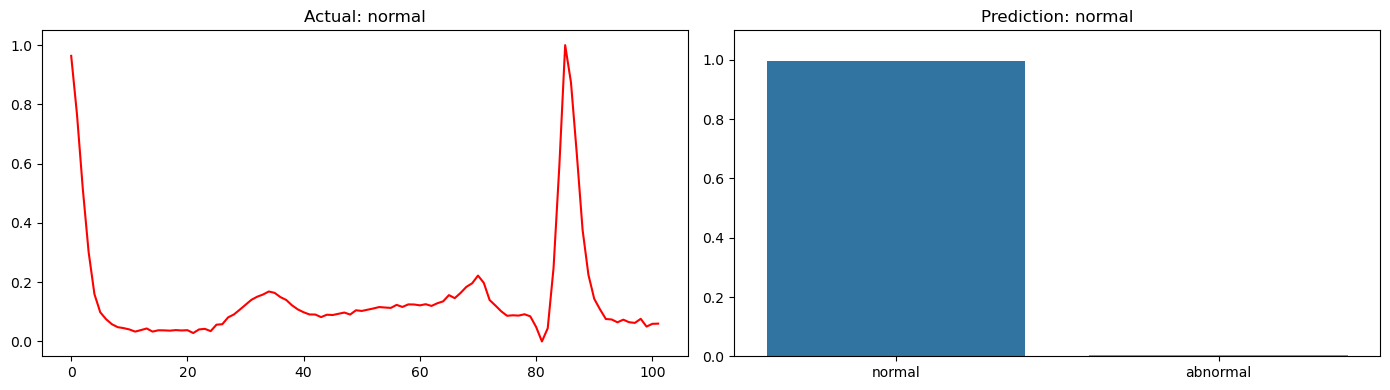

In [154]:
random_test()